# PCA/SVM methods for rearing detection

1. Organize the design matrix for PCA
2. Get the pattern for PCA

# 1. Load the data

# 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from base import MultiDaysBeaconPosition, BeaconPosition
from scipy.stats import sem
from utils.basic_utils import get_tags
from sklearn.decomposition import PCA

from utils.baseline_method import continuous_detection 

In [3]:
root_path = '../Data/Raw/'
rat_id = 'FS10'
rat_subdirectories = glob(root_path+rat_id+'/*/' )

tags = get_tags(rat_subdirectories)

## 1.1 For one tag of rat

In [4]:
tag_id = 0
this_tag = BeaconPosition(rat_subdirectories[tag_id], tags[tag_id], True, True) #position data of this tag

In [5]:
unit_time = np.mean(this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
print(unit_time) # average time for a bin

0.016694419627324594


# 2. Detect rearing roughly (using threshold first)

In [28]:
# set the parameters
save_fig = False # whether save the fig for the results

T = 200
tau = 10
group_step = 10 # so that no overlap between taus

height_thresh = 0.6 # threshold for height/z to determine rearing

# get some important variables
xy_speed = np.insert(this_tag.speed,0,0) # speed on xy planar insert 0 at the beginning of the speed array to make the size same
z_speed = np.divide(this_tag.position_data[1:,3] - this_tag.position_data[:-1,3], this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
z_speed = np.insert(z_speed,0,0) # insert 0 at the beginning of the speed array to make the size same 

z = this_tag.position_data[:,3]

# organize k features that we're interested in
k = 2
all_feature_matrix = np.zeros((k, len(z)))
all_feature_matrix[0,:] = z
all_feature_matrix[1,:] = this_tag.position_data[:,6]

In [15]:
def rearing_detection(z, height_thresh = 0.6):
    '''
    detect rearing by the height_thresh, if z[i]> = height_thresh, then the time of z[i] if rearing time
    z: array of height in time series
    height_thresh :threshold to determine the rearing
    
    return:
    r: array of index of rearing time
    '''
    
    return np.argwhere(z>= height_thresh).flatten()
    

In [68]:
def generate_tau_sample(before_matrix, tau = 10, step = 2):
    '''
    generate a matrix of tau length sample by slicing the window along the whole time series
    features: [n,k,T]
    
    return : array in[n*m, tau*k], m is the number of slice of tau for T long period
    '''
    # determine the size of the final output
    
    # use a time window to slip along T and get slice of tau, combine different features horizontally, 

    num_slice = T//tau # step = tau, no overlap
    num_events = before_matrix.shape[0]
    x_matrix = np.zeros((num_events * num_slice, tau * k))


    step = tau
    for i, end_idx in enumerate(np.arange(tau, T+1, step)):
        x_matrix[i*num_events: (i+1)*num_events, :] = np.hstack(np.transpose(before_matrix[:,:,end_idx - tau:end_idx],(1,0,2))) 
    
    
    return x_matrix

In [41]:
rearing_idx = rearing_detection(z, height_thresh= height_thresh)
whether_continue, rearing_periods = continuous_detection(rearing_idx, discontinu_tolerance= 10, total_tolerance= 20,seperate= True)

# rearing_periods: slice of different rearing events

In [42]:
# for each rearing event, get T length time before it
before_list = []
for i,this_rearing in enumerate(rearing_periods):
    begin_idx = this_rearing[0]
    if begin_idx - T >=0:
        before_list.append(all_feature_matrix[:,begin_idx - T: begin_idx])
before_matrix = np.asarray(before_list) # in shape [num_event, k, T]
num_events = before_matrix.shape[0]

In [69]:
# use a time window to slip along T and get slice of tau, combine different features horizontally, 
x_matrix = generate_tau_sample(before_matrix, tau =tau, step = tau)
    

# 3. Use PCA to detect the rearing period

In [83]:
# normalize x_matrix
x_norm = x_matrix - x_matrix.mean(axis=0)
pca = PCA(n_components= 10)
pca.fit(x_norm)

PCA(n_components=10)

In [86]:
eigen_vec = pca.components_
eigen_ratio = pca.explained_variance_ratio_

Text(0, 0.5, 'explaied variance')

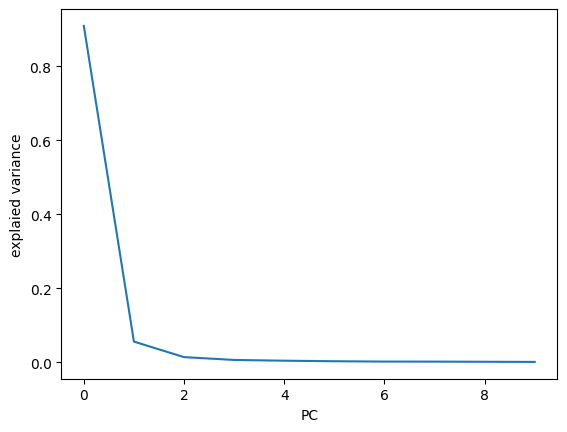

In [95]:
plt.plot(eigen_ratio)
plt.xlabel('PC')
plt.ylabel('explaied variance')

Text(0, 0.5, 'pitch')

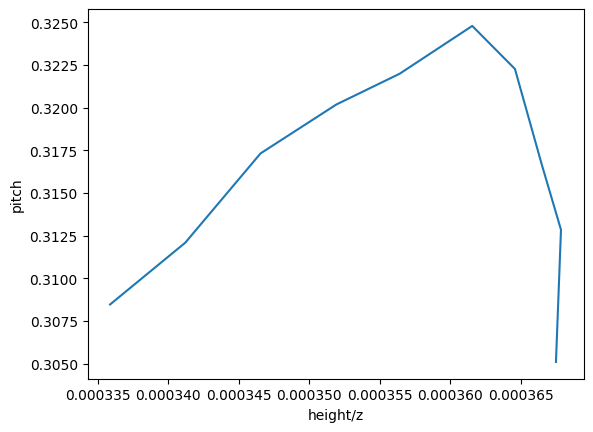

In [92]:
firt_pc = np.split(eigen_vec[0,:], k, axis = 0)
plt.plot(firt_pc[0],firt_pc[1])
plt.xlabel('height/z')
plt.ylabel('pitch')